In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('seminars/seminar8')

In [2]:
import torch
import torch.nn as nn
import torch.distributions as TD
from torch import Tensor
from torch.utils.data import DataLoader
import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Dict, List, Tuple

from dgm_utils import train_model
from seminar8_utils import ScoreMatcher, NoiseConditionedScoreNetwork

device = "cuda" if torch.cuda.is_available() else "cpu"

## Plan

We will look at:
1. **Slow mixing** of Langevin dynamics;
2. **Inaccurate score estimation** with score matching;
3. How NCSN solves the both problems;
4. How to choose the **hyperparameters** for NCSN.

Let us define our toy dataset wich is gaussian mixture:

In [3]:
class GMM:
    def __init__(self, probs: List, mus: List[List], sigmas: List[List], device: str="cpu") -> None:
        assert sum(probs) == 1.
        assert len(probs) == len(mus) == len(sigmas)
        self.probs = torch.tensor(probs, device=device)
        self.mus = torch.tensor(mus, device=device)
        self.sigmas = torch.stack([
            torch.diag(torch.tensor(sigma, device=device))
            for sigma in sigmas
        ])

        self.gmm = TD.MixtureSameFamily(
            TD.Categorical(self.probs),
            TD.MultivariateNormal(self.mus, covariance_matrix=self.sigmas)
        )
    
    def sample(self, shape: Tuple) -> Tensor:
        return self.gmm.sample(shape)

    def log_prob(self, samples: Tensor) -> Tensor:
        return self.gmm.log_prob(samples)

    def prob(self, samples: Tensor) -> Tensor:
        return self.log_prob(samples).exp()
    
    def score(self, samples: Tensor) -> Tensor:
        with torch.enable_grad():
            samples = samples.detach()
            samples.requires_grad_(True)
            log_prob = self.log_prob(samples).sum()
            return torch.autograd.grad(log_prob, samples)[0]
  
        
class InfiniteDataLoader(DataLoader):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Initialize an iterator over the dataset.
        self.dataset_iterator = super().__iter__()

    def __iter__(self):
        return self

    def __next__(self):
        try:
            batch = next(self.dataset_iterator)
        except StopIteration:
            # Dataset exhausted, use a new fresh iterator.
            self.dataset_iterator = super().__iter__()
            batch = next(self.dataset_iterator)
        return batch

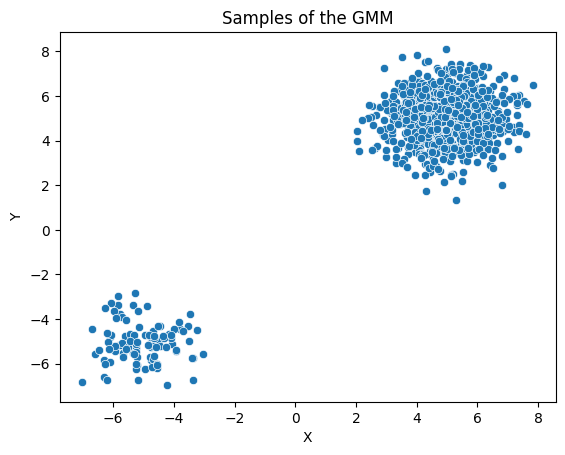

In [30]:
probs = [0.1, 0.90]
mus = np.asarray([
    [-1., -1.],
    [1., 1.]
]) * 5
sigmas = np.asarray([
    [1., 1.],
    [1., 1.]
])
gmm = GMM(probs, mus, sigmas, device=device)

samples = gmm.sample((1000,)).cpu()
sns.scatterplot(x=samples[:, 0], y=samples[:, 1])
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Samples of the GMM")
plt.show()

And not the Langevine dynamics it self:

In [31]:
class LangevinDynamics:
    def __init__(self, score_fn: Callable, step_size: Tensor) -> None:
        self.score_fn = score_fn
        self.step_size = step_size
    
    def step(self, xt: Tensor, **kwargs: Dict) -> Tensor:
        noise = torch.randn_like(xt)
        return (
            xt + 
            0.5 * self.step_size * self.score_fn(xt, **kwargs) +
            self.step_size.sqrt() * noise
        )

    def __call__(self, xt: Tensor, num_steps: int, **kwargs) -> Tensor:
        for _ in range(num_steps):
            xt = self.step(xt, **kwargs)
        return xt

###  Slow mixing of Langevin dynamics

When two modes of the data distribution are separated by low density regions, Langevin Dymamics will not be able to correctly recover the relative weights of these two modes in reasonable time, and therefore might not converge to the true distribution.

Consider a mixture distribution
$p_{\text{data}}(x) = \alpha p_1(x) + (1 - \alpha) p_2(x)$, where $p_1(x)$ and $p_2(x)$ are normalized distributions with disjoint supports, and $\alpha \in (0, 1)$. Lets look at the gradients in supports of $p_1(x)$ and $p_2(x)$:

1. $p_1(x)$: $\nabla_x \log p_{\text{data}}(x) = \nabla_x (\log \alpha + \log p_1(x)) = \nabla_x \log p_1(x)$,
2. $p_2(x)$: $\nabla_x \log p_{\text{data}}(x) = \nabla_x (\log (1 - \alpha) + \log p_2(x)) = \nabla_x \log p_2(x)$.

In either case, the score $\nabla_x \log p_{\text{data}}(x)$ **does not depend** on $\alpha$.

Since Langevin Dynamics use $\nabla_x \log p_{\text{data}}(x)$ to sample from $p_{\text{data}}(x)$, the samples obtained will not depend on $\alpha$.

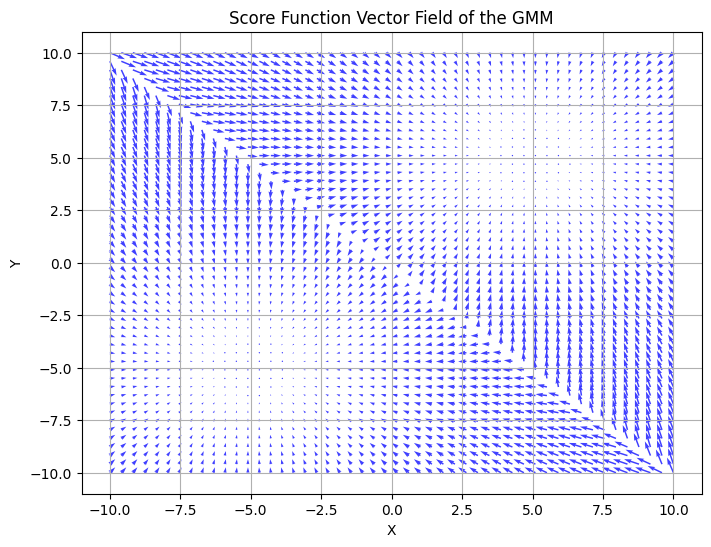

In [32]:
# Define the range for x and y values for grid points
x = np.linspace(-10, 10, 50)
y = np.linspace(-10, 10, 50)

# Create a meshgrid for x and y values
X, Y = np.meshgrid(x, y)
positions = np.vstack([X.ravel(), Y.ravel()]).T
positions_tensor = torch.tensor(positions, dtype=torch.float32)

# Calculate the score for each grid point
score = gmm.score(positions_tensor.to(device)).cpu()

# Convert score to numpy arrays for plotting
U = score[:, 0].detach().numpy().reshape(X.shape)  # x-component of the score
V = score[:, 1].detach().numpy().reshape(Y.shape)  # y-component of the score

# Plot: Vector field of the score function
plt.figure(figsize=(8, 6))
plt.quiver(X, Y, U, V, color="blue", alpha=0.75)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Score Function Vector Field of the GMM")
plt.grid(True)
plt.show()

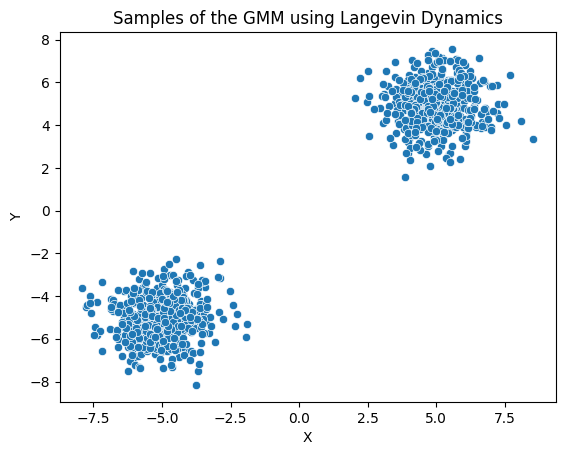

In [33]:
ld = LangevinDynamics(step_size=torch.tensor(0.01), score_fn=gmm.score)

num_steps = 1000
x_start = (torch.rand((1000, 2)) - 0.5) * 16.
generations = ld(x_start.to(device), num_steps).cpu()
sns.scatterplot(x=generations[:, 0], y=generations[:, 1])
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Samples of the GMM using Langevin Dynamics")
plt.show()

## Ill-estimated score in low data density regions

Pay your attention to the fact, that we estimate the score-function only nearby to our dataset, which according to the manifold hypothesis lies on a low dimensional manifold.

That means, that our trained score-model is ill-estimated at most of the $\mathbb{R}^D$. As a result, starting from random point and using Langevin Dynamics we are highly probable to fail to converge to the given distribution.

Let us define the Score Model:

In [34]:
class ScoreModel(nn.Module):
    def __init__(
        self, in_dim: int, hidden_dim: int
    ) -> None:
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, in_dim),
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.backbone(x)

In [35]:
score_model = ScoreModel(2, 128).to(device)
estimate_ld = LangevinDynamics(step_size=torch.tensor(0.1), score_fn=score_model)

matcher = ScoreMatcher(
    score_model=score_model, 
    input_shape=(2,), 
    score_fn=gmm.score,
    langevin_dynamics=estimate_ld
)

train_loader = InfiniteDataLoader(samples.to(torch.float32), batch_size=128, shuffle=True)
test_loader = InfiniteDataLoader(samples.to(torch.float32), batch_size=128, shuffle=False)

optimizer = torch.optim.Adam(matcher.parameters(), lr=0.001)

train_model(
    matcher,
    train_loader,
    test_loader,
    epochs=1,
    optimizer=optimizer,
    device=device,
    visualize_samples=False,
    logscale_y=True,
)

Start of the training


Training epoch 1:   0%|          | 0/8 [00:00<?, ?it/s]

KeyboardInterrupt: 

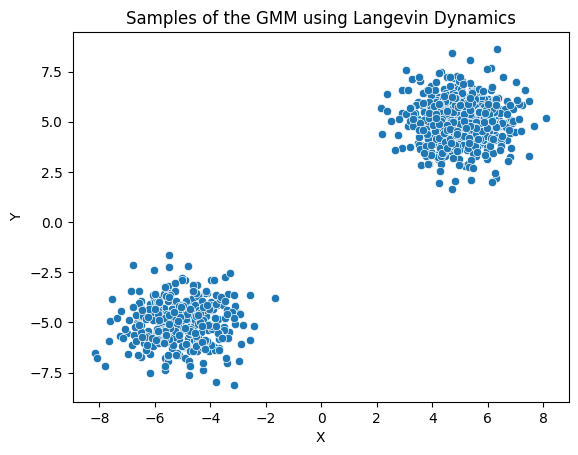

In [36]:
num_steps = 1000
generations = matcher.sample(1000, num_steps=num_steps).cpu()

sns.scatterplot(x=generations[:, 0], y=generations[:, 1])
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Samples of the GMM using Langevin Dynamics")
plt.show()

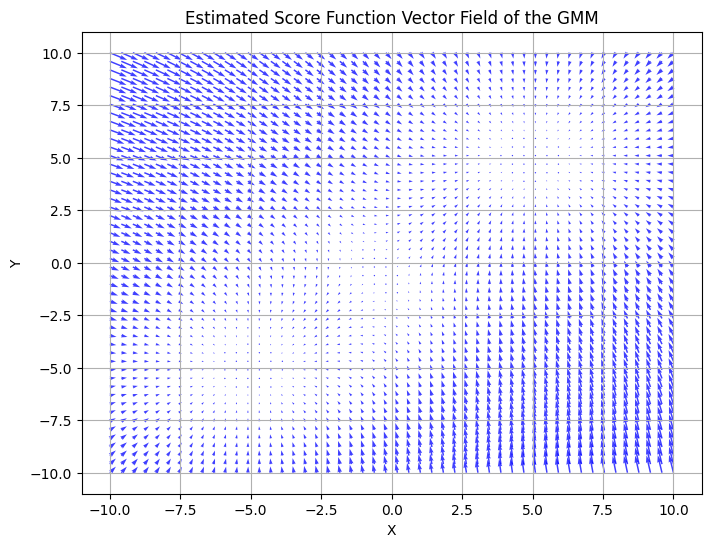

In [37]:
# Define the range for x and y values for grid points
x = np.linspace(-10, 10, 50)
y = np.linspace(-10, 10, 50)

# Create a meshgrid for x and y values
X, Y = np.meshgrid(x, y)
positions = np.vstack([X.ravel(), Y.ravel()]).T
positions_tensor = torch.tensor(positions, dtype=torch.float32)

# Calculate the score for each grid point
score = score_model(positions_tensor.to(device)).cpu()

# Convert score to numpy arrays for plotting
U = score[:, 0].detach().numpy().reshape(X.shape)  # x-component of the score
V = score[:, 1].detach().numpy().reshape(Y.shape)  # y-component of the score

# Plot: Vector field of the score function
plt.figure(figsize=(8, 6))
plt.quiver(X, Y, U, V, color="blue", alpha=0.75)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Estimated Score Function Vector Field of the GMM")
plt.grid(True)
plt.show()

## Solution of the problems using NCSN

**Main idea** is perturbing data with Gaussian noise.

1. Since the support of Gaussian noise distribution is the whole space, the perturbed data will not be confined to a low dimensional manifold, which obviates difficulties from the manifold hypothesis and makes score estimation well-defined.

2. Large Gaussian noise has the effect of filling low density regions in the original unperturbed data distribution; therefore score matching may get more training signal to improve score estimation.

In [38]:
class ConditionalScoreModel(nn.Module):
    def __init__(
        self, in_dim: int, sigma_emb_dim: int, hidden_dim: int
    ) -> None:
        super().__init__()
        self.sigma_emb = nn.Sequential(
            nn.Linear(1, sigma_emb_dim),
            nn.Softplus(),
            nn.Linear(sigma_emb_dim, sigma_emb_dim),
        )
        self.backbone = nn.Sequential(
            nn.Linear(in_dim + sigma_emb_dim, hidden_dim),
            nn.Softplus(),
            nn.Linear(hidden_dim, in_dim),
        )

    def forward(self, x: Tensor, sigma: Tensor) -> Tensor:
        sigma = sigma.float().unsqueeze(1)
        sigma_emb = self.sigma_emb(sigma)
        x = torch.cat([x, sigma_emb], dim=1)
        return self.backbone(x)

In [39]:
cond_score_model = ConditionalScoreModel(2, 16, 128).to(device)
estimate_ld = LangevinDynamics(step_size=torch.tensor(0.1), score_fn=cond_score_model)

sigma_1 = 8.
sigma_L = 0.1
L = 10
sigmas = [
    sigma_1 * (sigma_L/sigma_1)**((i)/(L-1)) for i in range(L)
]
matcher = NoiseConditionedScoreNetwork(
    score_model=cond_score_model, 
    input_shape=(2,), 
    sigmas=sigmas,
    langevin_dynamics=estimate_ld
)

train_loader = InfiniteDataLoader(samples.to(torch.float32), batch_size=128, shuffle=True)
test_loader = InfiniteDataLoader(samples.to(torch.float32), batch_size=128, shuffle=False)

optimizer = torch.optim.Adam(matcher.parameters(), lr=0.001)

train_model(
    matcher,
    train_loader,
    test_loader,
    epochs=1,
    optimizer=optimizer,
    device=device,
    visualize_samples=False,
    logscale_y=True,
)

Start of the training


Training epoch 1:   0%|          | 0/8 [00:00<?, ?it/s]

KeyboardInterrupt: 

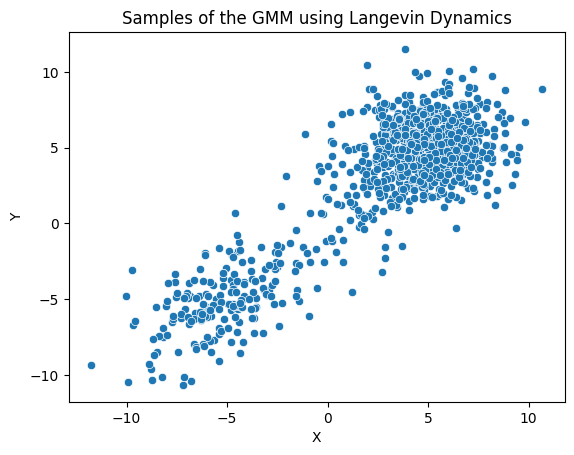

In [40]:
num_steps = 1000
generations = matcher.sample(1000, num_steps=num_steps).cpu()

sns.scatterplot(x=generations[:, 0], y=generations[:, 1])
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Samples of the GMM using Langevin Dynamics")
plt.show()

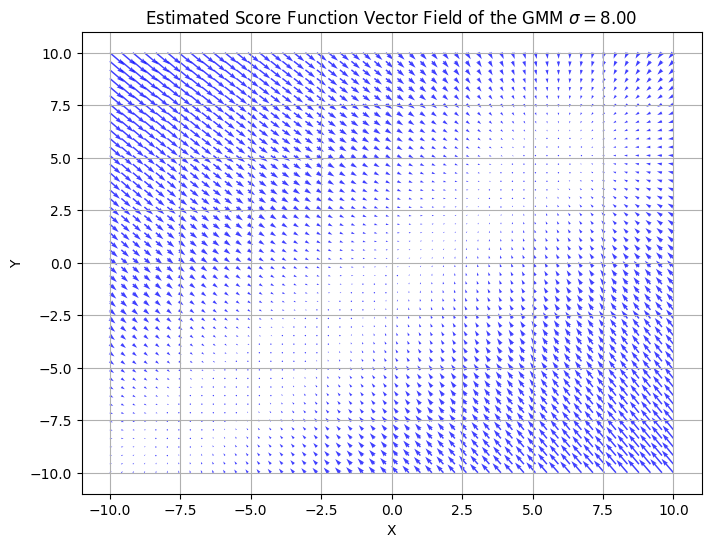

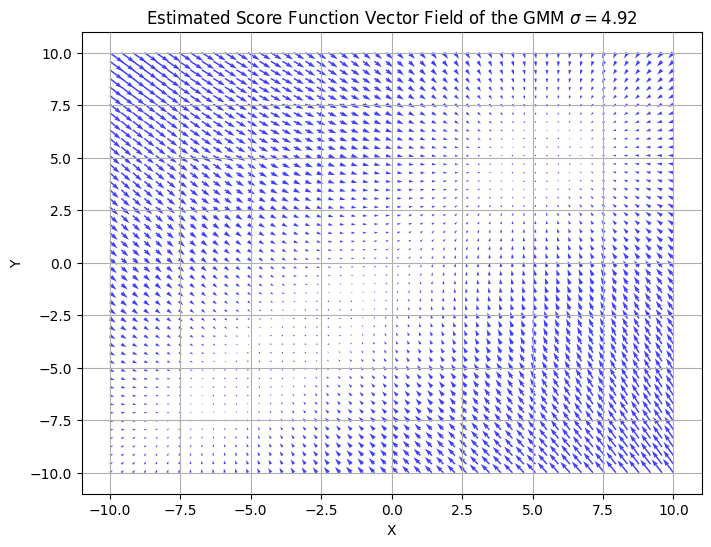

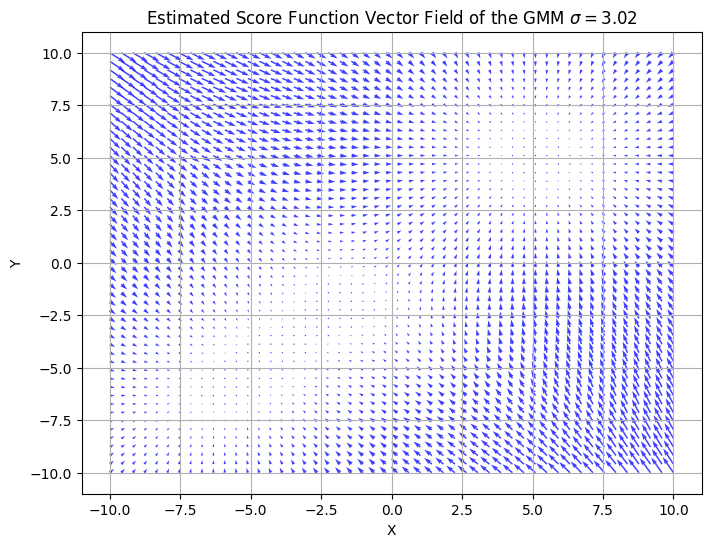

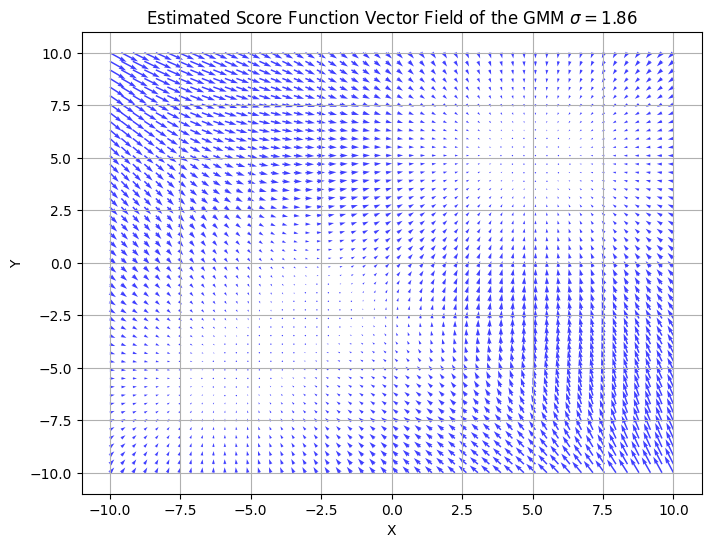

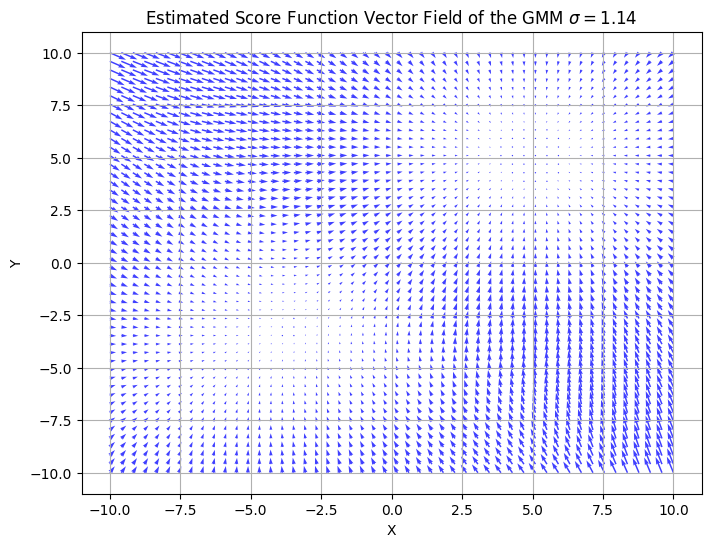

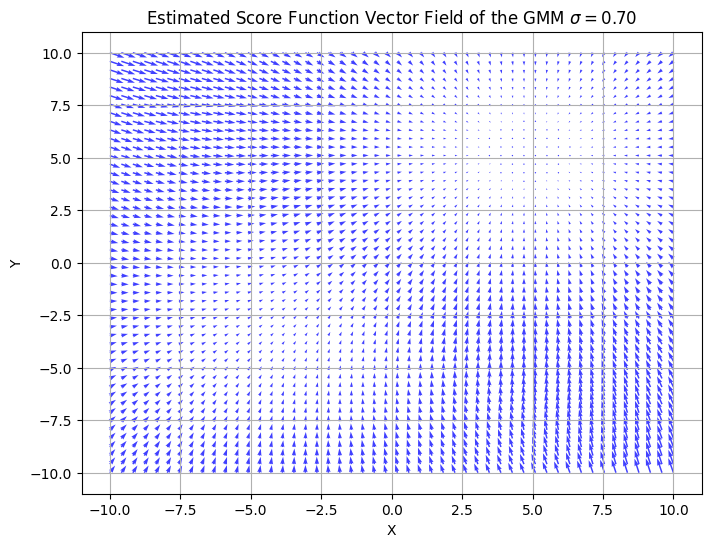

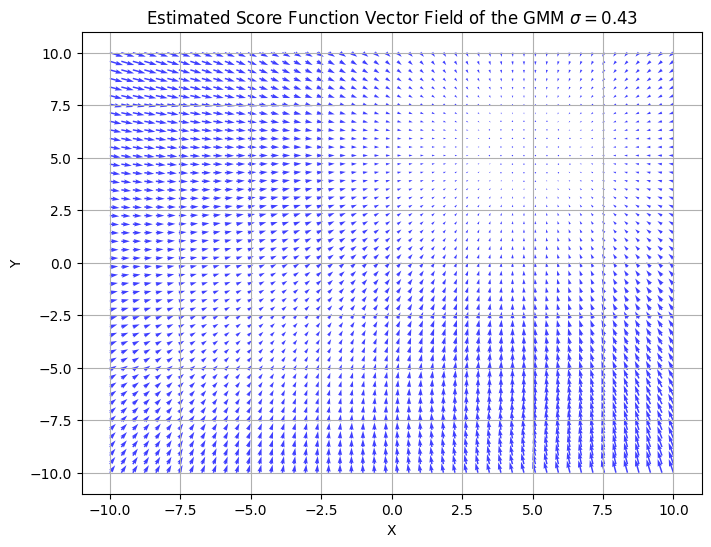

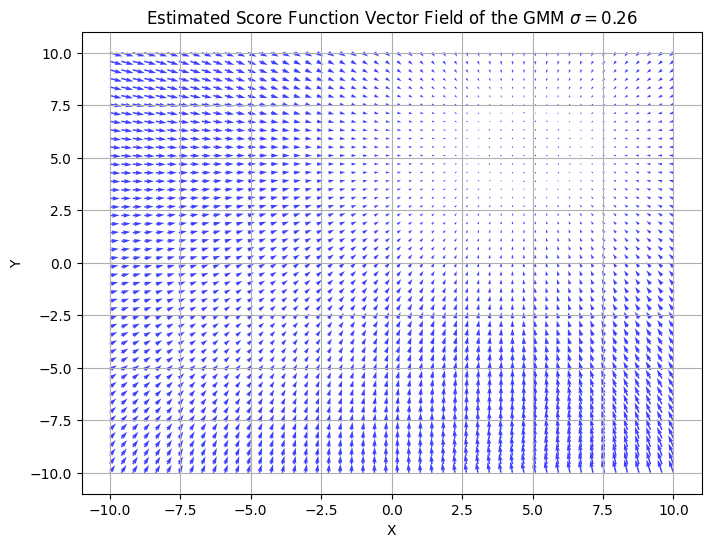

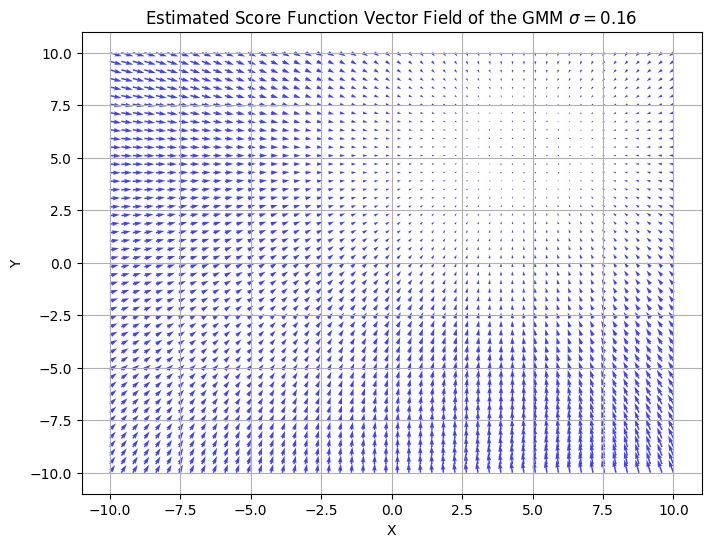

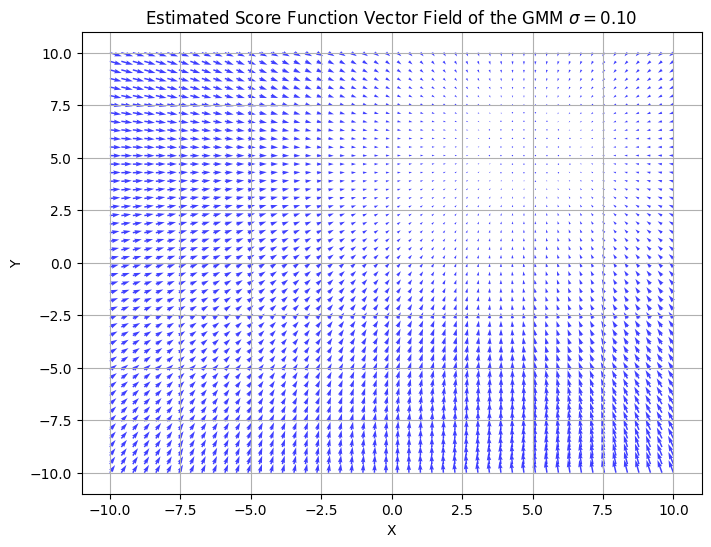

In [41]:
# Define the range for x and y values for grid points
x = np.linspace(-10, 10, 50)
y = np.linspace(-10, 10, 50)

# Create a meshgrid for x and y values
X, Y = np.meshgrid(x, y)
positions = np.vstack([X.ravel(), Y.ravel()]).T
positions_tensor = torch.tensor(positions, dtype=torch.float32)

for sigma in sigmas:
    # Calculate the score for each grid point
    sigma = torch.full(size=(positions_tensor.shape[0],), fill_value=sigma, device=device)
    score = cond_score_model(positions_tensor.to(device), sigma).cpu()

    # Convert score to numpy arrays for plotting
    U = score[:, 0].detach().numpy().reshape(X.shape)  # x-component of the score
    V = score[:, 1].detach().numpy().reshape(Y.shape)  # y-component of the score

    # Plot: Vector field of the score function
    plt.figure(figsize=(8, 6))
    plt.quiver(X, Y, U, V, color="blue", alpha=0.75)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(f"Estimated Score Function Vector Field of the GMM $\sigma={sigma[0].item():.2f}$")
    plt.grid(True)
    plt.show()

## How to choose hyperparameters?
Details in the [paper](https://arxiv.org/abs/2006.09011).

**Technique 0**:
choose $\sigma_L$ in a way that $q_{\sigma_L}(x) \approx \pi(x)$.

**Technique 1** (Initial noise scale):
choose $\sigma_1$ to be as large as the maximum Euclidean distance between all pairs of training data points.

**Technique 2** (Other noise scales):
choose $\{\sigma_i\}$ as a geometric prograeession with a common ratio $\gamma$,
such that $\Phi(\sqrt{2D}(\gamma - 1) + 3 \gamma) - \Phi(\sqrt{2D}(\gamma - 1) - 3 \gamma) \approx 0.5$, where $D$ is a data dimensionality (should be large).

**Technique 3** (selecting $T$ and $\epsilon$):
choose $T$ as large as allowed by a computing budget and then select an
$\epsilon$ that makes equation below maximally close to 1.

$$
    f(\epsilon)
    =
    \left(
        1 - \frac{\epsilon}{\sigma_L^2}
    \right)^{2T}
    \left(
        \gamma^2
        -
        \frac{
            2 \epsilon
        }{
            \sigma_L^2
            -
            \sigma_L^2
            (1 - \frac{\epsilon}{\sigma_L^2})^2
        }
    \right)
    +
    \frac{
        2 \epsilon
    }{
        \sigma_L^2
        -
        \sigma_L^2
        (1 - \frac{\epsilon}{\sigma_L^2})^2
    }
$$